## **Importing Libraries**

Importing required libraries for handling the data and Anomaly Detection.

**This Notebook follows exactly the same procedure as done for CPU_usage, I used this dataset to see what difference does the data make for anomaly detection using the same models.**

In [1]:
# Importing libraries required for handling the data
import pandas as pd
import numpy as np

# Importing libraries required for visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns

# Importing libraries required for importing the data
from google.colab import files
import io

# Importing libraries for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing ML Models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

Uploading the data file

In [2]:
uploaded = files.upload()

Saving nyc_taxi.csv to nyc_taxi.csv


Reading the data file into a pandas dataframe.

In [3]:
path = io.BytesIO(uploaded['nyc_taxi.csv'])
df = pd.read_csv(path)

## **Pre-Processing the dataset**

Converting the timestamp feature into a datetime format for pandas, using that as index and sorting the dataset.<br>


Cleaning the data by dropping any na values, none of those exists in the dataset as nothing gets dropped.

Also creating the one day usage dataset using the index.

Printing the head and tail of the dataset.

In [4]:
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
df.dropna(inplace=True)
df = df.set_index("timestamp")
df.sort_index(inplace=True)
df_oneDayUsage = df[df.index < '2014-07-02 00:00:00']
print("Dataset Shape:",df.shape)
df.head()

Dataset Shape: (10320, 1)


,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [5]:
df.tail()

,value
timestamp,
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309
2015-01-31 23:00:00,26591
2015-01-31 23:30:00,26288


After looking at the data we can see the data is in 30 minutes interval, and we have 10,320 data points starting on July 1st 2014 at 00:00:00 and ending on January 31st 2015 at 23:30:00. 

Visualizing the whole dataset

[Text(0, 0.5, 'Value'), Text(0.5, 0, 'Timestamp')]

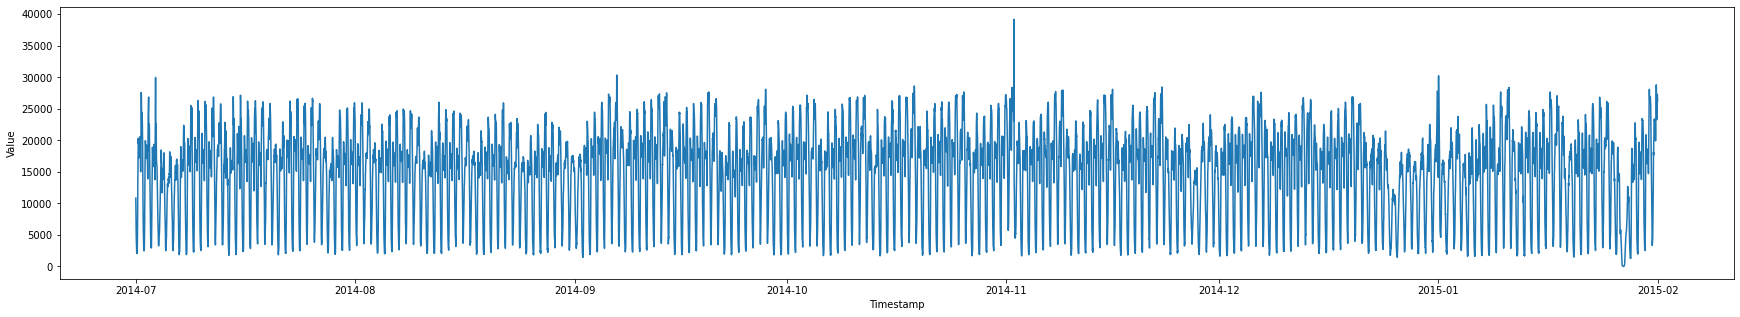

In [6]:
plt.figure(figsize=(30,5))
ax = sns.lineplot(x=df.index,y='value', data=df)
ax.set(ylabel='Value', xlabel='Timestamp')

Visualizing parts of the dataset
 * One Day
 * One Week
 * One Month


Text(0, 0.5, 'Value')

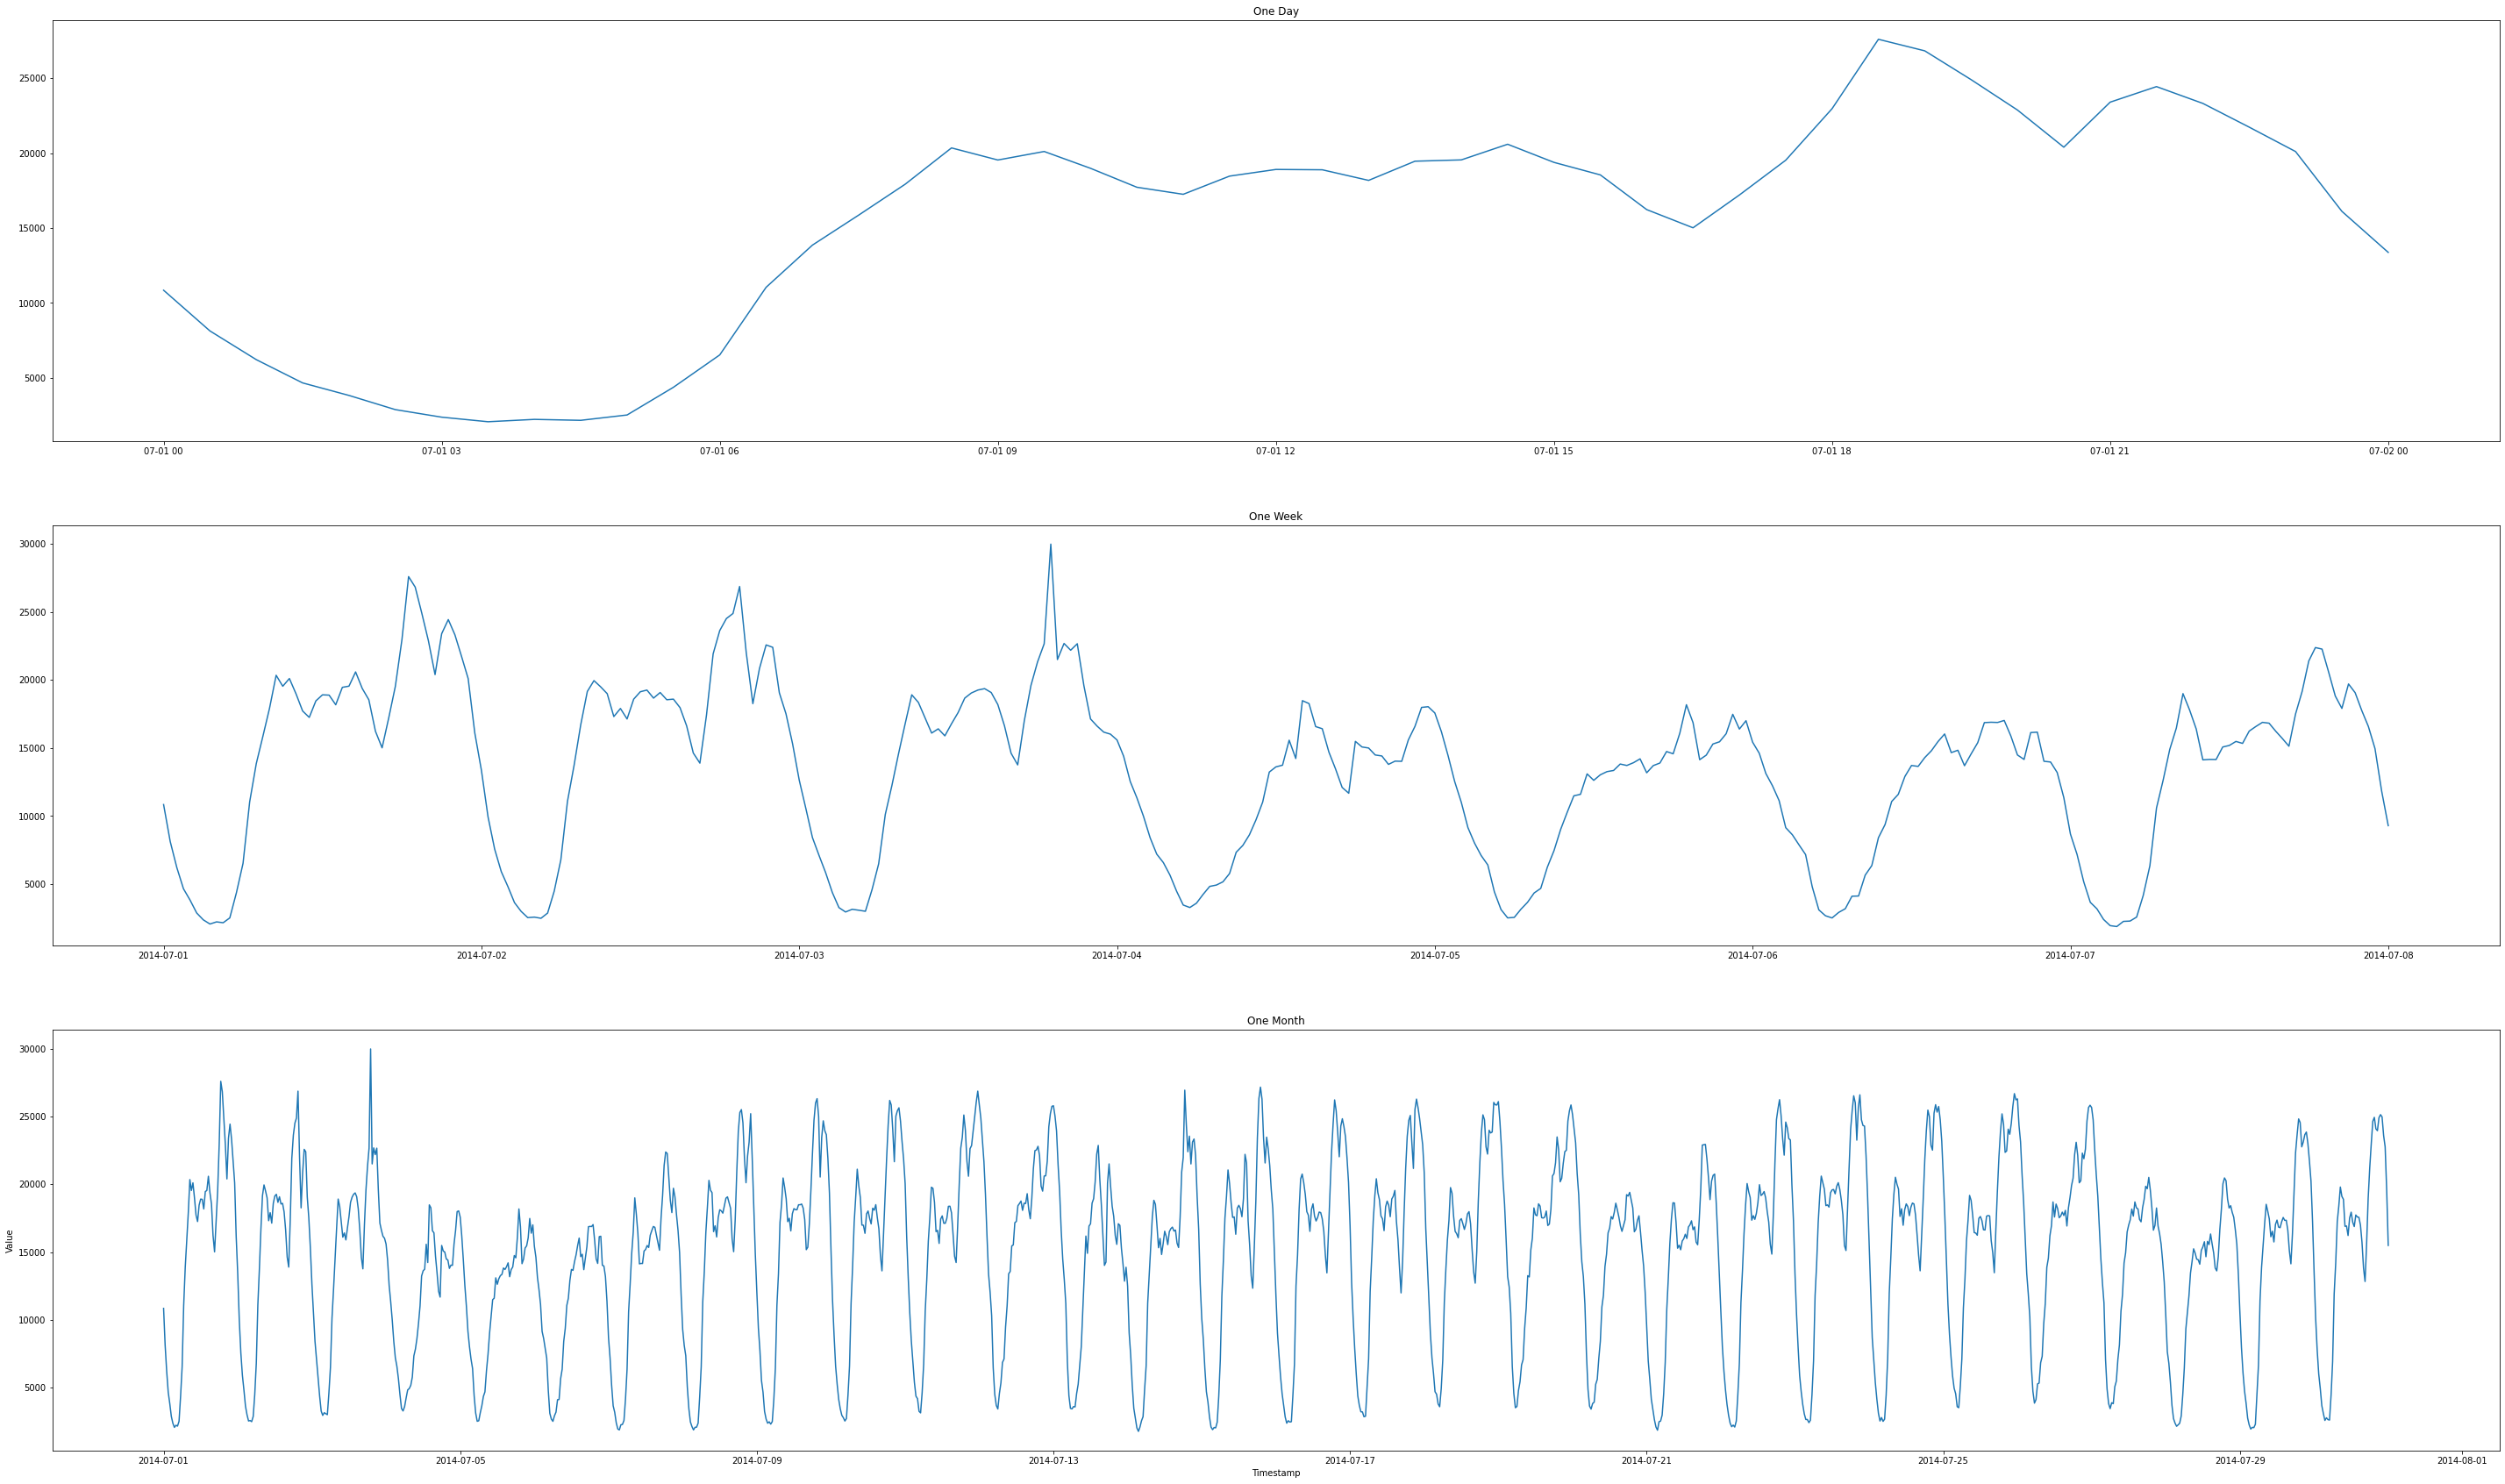

In [7]:
fig, axs = plt.subplots(3, figsize=(50,30))
axs[0].plot(df.index[df.index <= '2014-07-02 00:00:00'],'value', data = df[df.index <= '2014-07-02 00:00:00'],label='One Day')
axs[0].set_title('One Day')

axs[1].plot(df.index[df.index <= '2014-07-08 00:00:00'],'value', data = df[df.index <= '2014-07-08 00:00:00'], label='One Week')
axs[1].set_title('One Week')

axs[2].plot(df.index[df.index <= '2014-07-31 00:00:00'],'value', data = df[df.index <= '2014-07-31 00:00:00'], label = 'July')
axs[2].set_title('One Month')

axs[2].set_xlabel('Timestamp')
axs[2].set_ylabel('Value')

Creating a Per hour average usage for the dataset, as the dataset is in 30 minutes interval we know there are 2 values within an hour so averaging on those two values and visualizing the difference.

[Text(0, 0.5, 'Value'), Text(0.5, 0, 'Per Hour')]

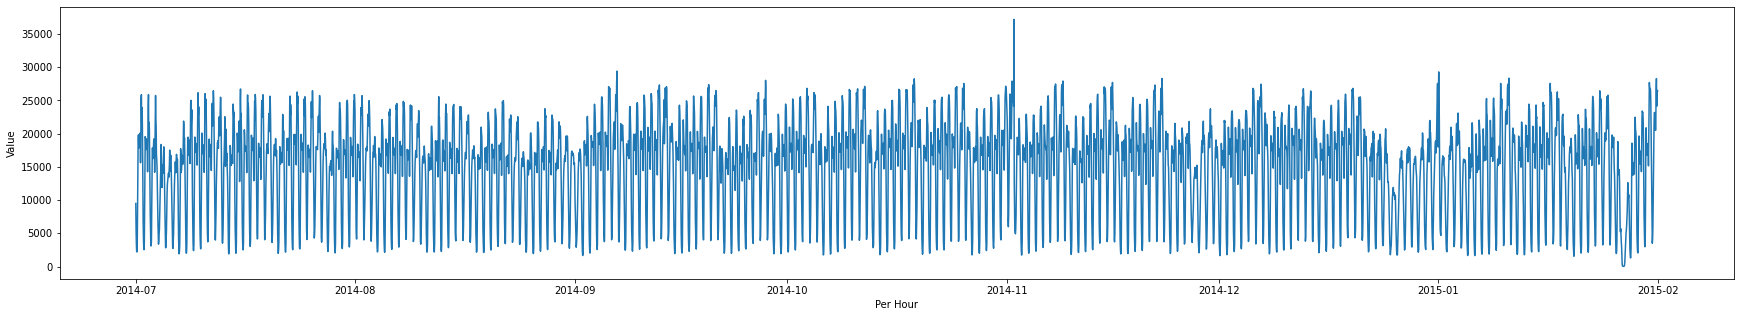

In [8]:
timeSeries_PerHour = (df['value'].resample('60min').sum()/2).to_frame() # Calculating per hour average usage
plt.figure(figsize=(30,5))
ax = sns.lineplot(x=timeSeries_PerHour.index,y='value', data=timeSeries_PerHour)
ax.set(ylabel='Value', xlabel='Per Hour')

As we can see from the plotted graph above, the per hour average smooths out the overall dataset and reduces some noise. This could be helpful as the model could perform better for predicting anomalies at a specific hour.

**Shape of all the datasets used**

In [9]:
print("Whole Dataset Shape:", df.shape)
print("One day usage df shape:", df_oneDayUsage.shape)
print("Per Hour average df shape:", timeSeries_PerHour.shape)

Whole Dataset Shape: (10320, 1)
One day usage df shape: (48, 1)
Per Hour average df shape: (5160, 1)


From the shapes above we can see that the whole dataset has 10,320 values, one day has only 48 values, and the per hour average of the whole dataset has 5,160 values which is half of the original dataset used for averaging.

## **Scaling the dataset**

A scaled dataset is good for training a ML model so we scale the different dataframes using the standard scaler function from the sklearn preprocessing library.

In [10]:
scaler = StandardScaler()
scaler_odu = StandardScaler()
scaler_avg = StandardScaler()

scaled_df = pd.DataFrame(data=scaler.fit_transform(np.array(df['value']).reshape(-1,1)),index=df.index,columns=['value'])
scaled_oneday_df = pd.DataFrame(data=scaler_odu.fit_transform(np.array(df_oneDayUsage['value']).reshape(-1,1)),index=df_oneDayUsage.index,columns=['value'])
scaled_perHour = pd.DataFrame(scaler_avg.fit_transform(np.array(timeSeries_PerHour['value']).reshape(-1,1)),index=timeSeries_PerHour.index,columns=['value'])

## **Implementing ML Models**

* Local Outlier Factor
* Isolation Forest
* DBSCAN

Implemented on:

* The whole dataset
* One day usage (24 hours)
* Per Hour average

Visualized the predicted anomalies:<br>
 **Blue Line - Actual data**<br>
 **Red Dots - Anomalies Detected**

In [11]:
pd.options.mode.chained_assignment = None  # default='warn'

# Initializing models with hyperparameters
model_lof = LocalOutlierFactor(contamination= 0.1,n_neighbors=10)
model_if =  IsolationForest(contamination= 0.1,max_samples=100, random_state=1)
model_DBSCAN = DBSCAN(eps = 0.01, min_samples=5)

# Fitting and predicting on the whole dataset with different models.
df['Predictions_DBSCAN'] = model_DBSCAN.fit_predict(scaled_df)
df['Predictions_LocalOutlierFactor'] = model_lof.fit_predict(scaled_df)
df['Predictions_IsolationForest'] = model_if.fit_predict(scaled_df)

# Fitting and predicting for one day usage with different models.
df_oneDayUsage['Predictions_DBSCAN'] = model_DBSCAN.fit_predict(scaled_oneday_df)
df_oneDayUsage['Predictions_LocalOutlierFactor'] = model_lof.fit_predict(scaled_oneday_df)
df_oneDayUsage['Predictions_IsolationForest'] = model_if.fit_predict(scaled_oneday_df)

# Fitting and predicting for one day 10 mins average with different models.
timeSeries_PerHour['Predictions_DBSCAN'] = model_DBSCAN.fit_predict(scaled_perHour)
timeSeries_PerHour['Predictions_LocalOutlierFactor'] = model_lof.fit_predict(scaled_perHour)
timeSeries_PerHour['Predictions_IsolationForest'] = model_if.fit_predict(scaled_perHour)

# df.head()
# df_oneDayUsage.head()
# timeSeries_Per10mins.head()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_iforest.py:281: UserWarning: max_samples (100) is greater than the total number of samples (48). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


Plotting graphs for predictions (anomalies) on one day usage of taxi in New York City.

For this dataset the one day usage was not as useful as I thought, also we can see that for DBSCAN it detects mostly every point/value as an anomaly in this dataset.

I think Isolation Forest worked the best for the one day NYC taxi usage.

Text(0.5, 1.0, 'DBSCAN')

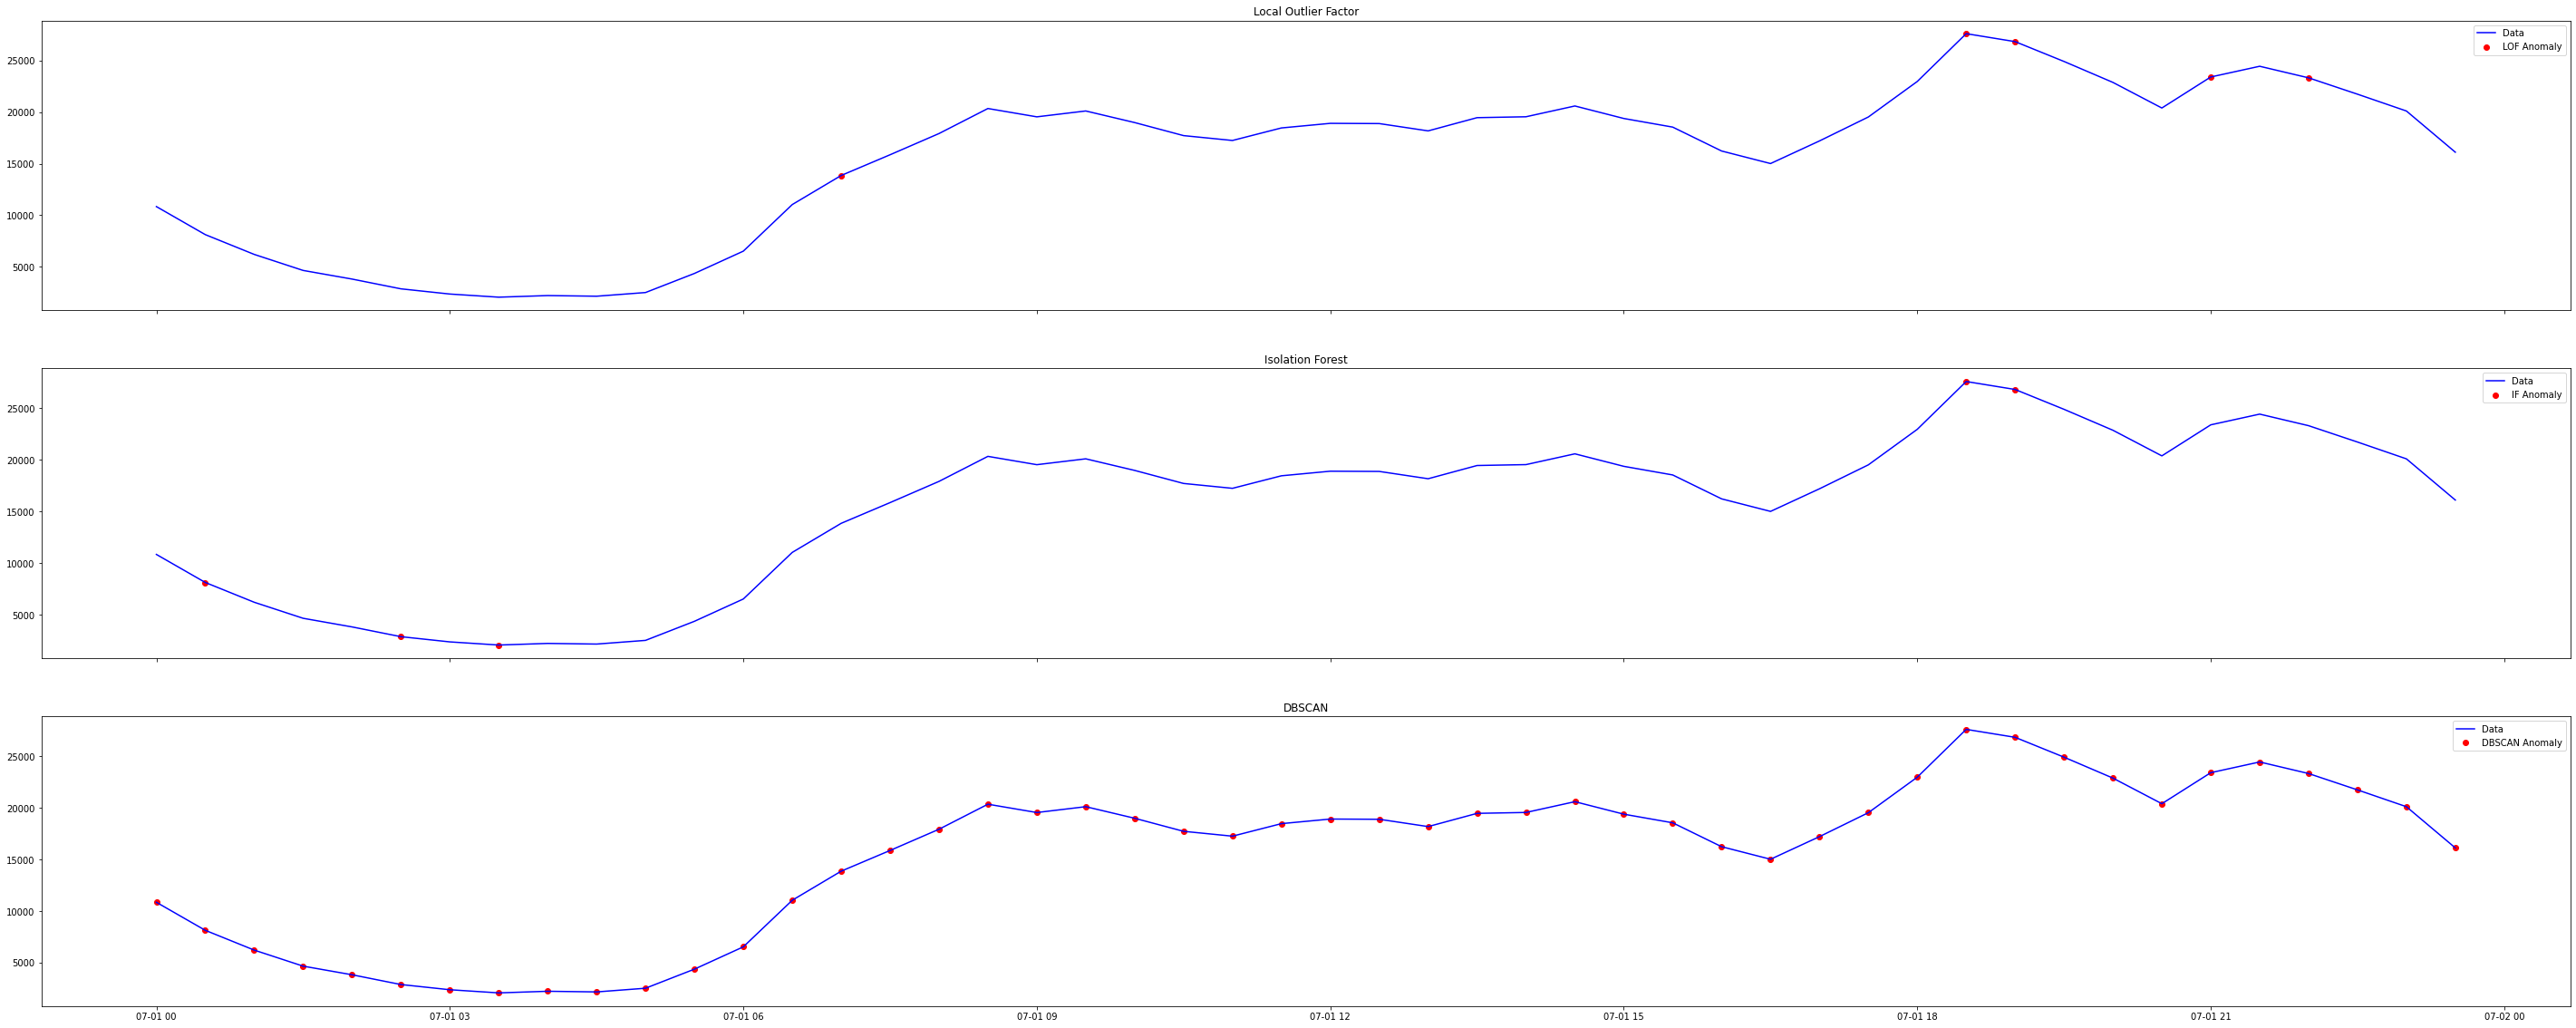

In [12]:
lof_outliers = df_oneDayUsage.loc[df_oneDayUsage['Predictions_LocalOutlierFactor'] == -1, ['value']] # -1 is an anomaly
if_outliers = df_oneDayUsage.loc[df_oneDayUsage['Predictions_IsolationForest'] == -1, ['value']] # -1 is an anomaly
dbscan_outliers = df_oneDayUsage.loc[df_oneDayUsage['Predictions_DBSCAN'] == -1, ['value']] # -1 is an anomaly

fig, axs = plt.subplots(3, figsize=(50,20),sharex=True,sharey=True)
axs[0].plot(df_oneDayUsage.index, df_oneDayUsage['value'], color='blue', label = 'Data')
axs[0].scatter(x=lof_outliers.index,y=lof_outliers['value'], color='red', label = 'LOF Anomaly')
axs[0].legend()
axs[0].set_title('Local Outlier Factor')

axs[1].plot(df_oneDayUsage.index, df_oneDayUsage['value'], color='blue', label = 'Data')
axs[1].scatter(x=if_outliers.index,y=if_outliers['value'], color='red', label = 'IF Anomaly')
axs[1].legend()
axs[1].set_title('Isolation Forest')

axs[2].plot(df_oneDayUsage.index, df_oneDayUsage['value'], color='blue', label = 'Data')
axs[2].scatter(x=dbscan_outliers.index,y=dbscan_outliers['value'], color='red', label = 'DBSCAN Anomaly')
axs[2].legend()
axs[2].set_title('DBSCAN')

Plotting predictions (anomalies) for Per hour average taxi usage in NYC.

The per hour average of the whole dataset, did give us a smoother graph and hence reduced the fluctuations which I think did help for this dataset. We can predict the per hour activity for taxi usage in NYC.

Again I think Isolation Forest worked the best for this dataset as well.

Text(0.5, 1.0, 'DBSCAN')

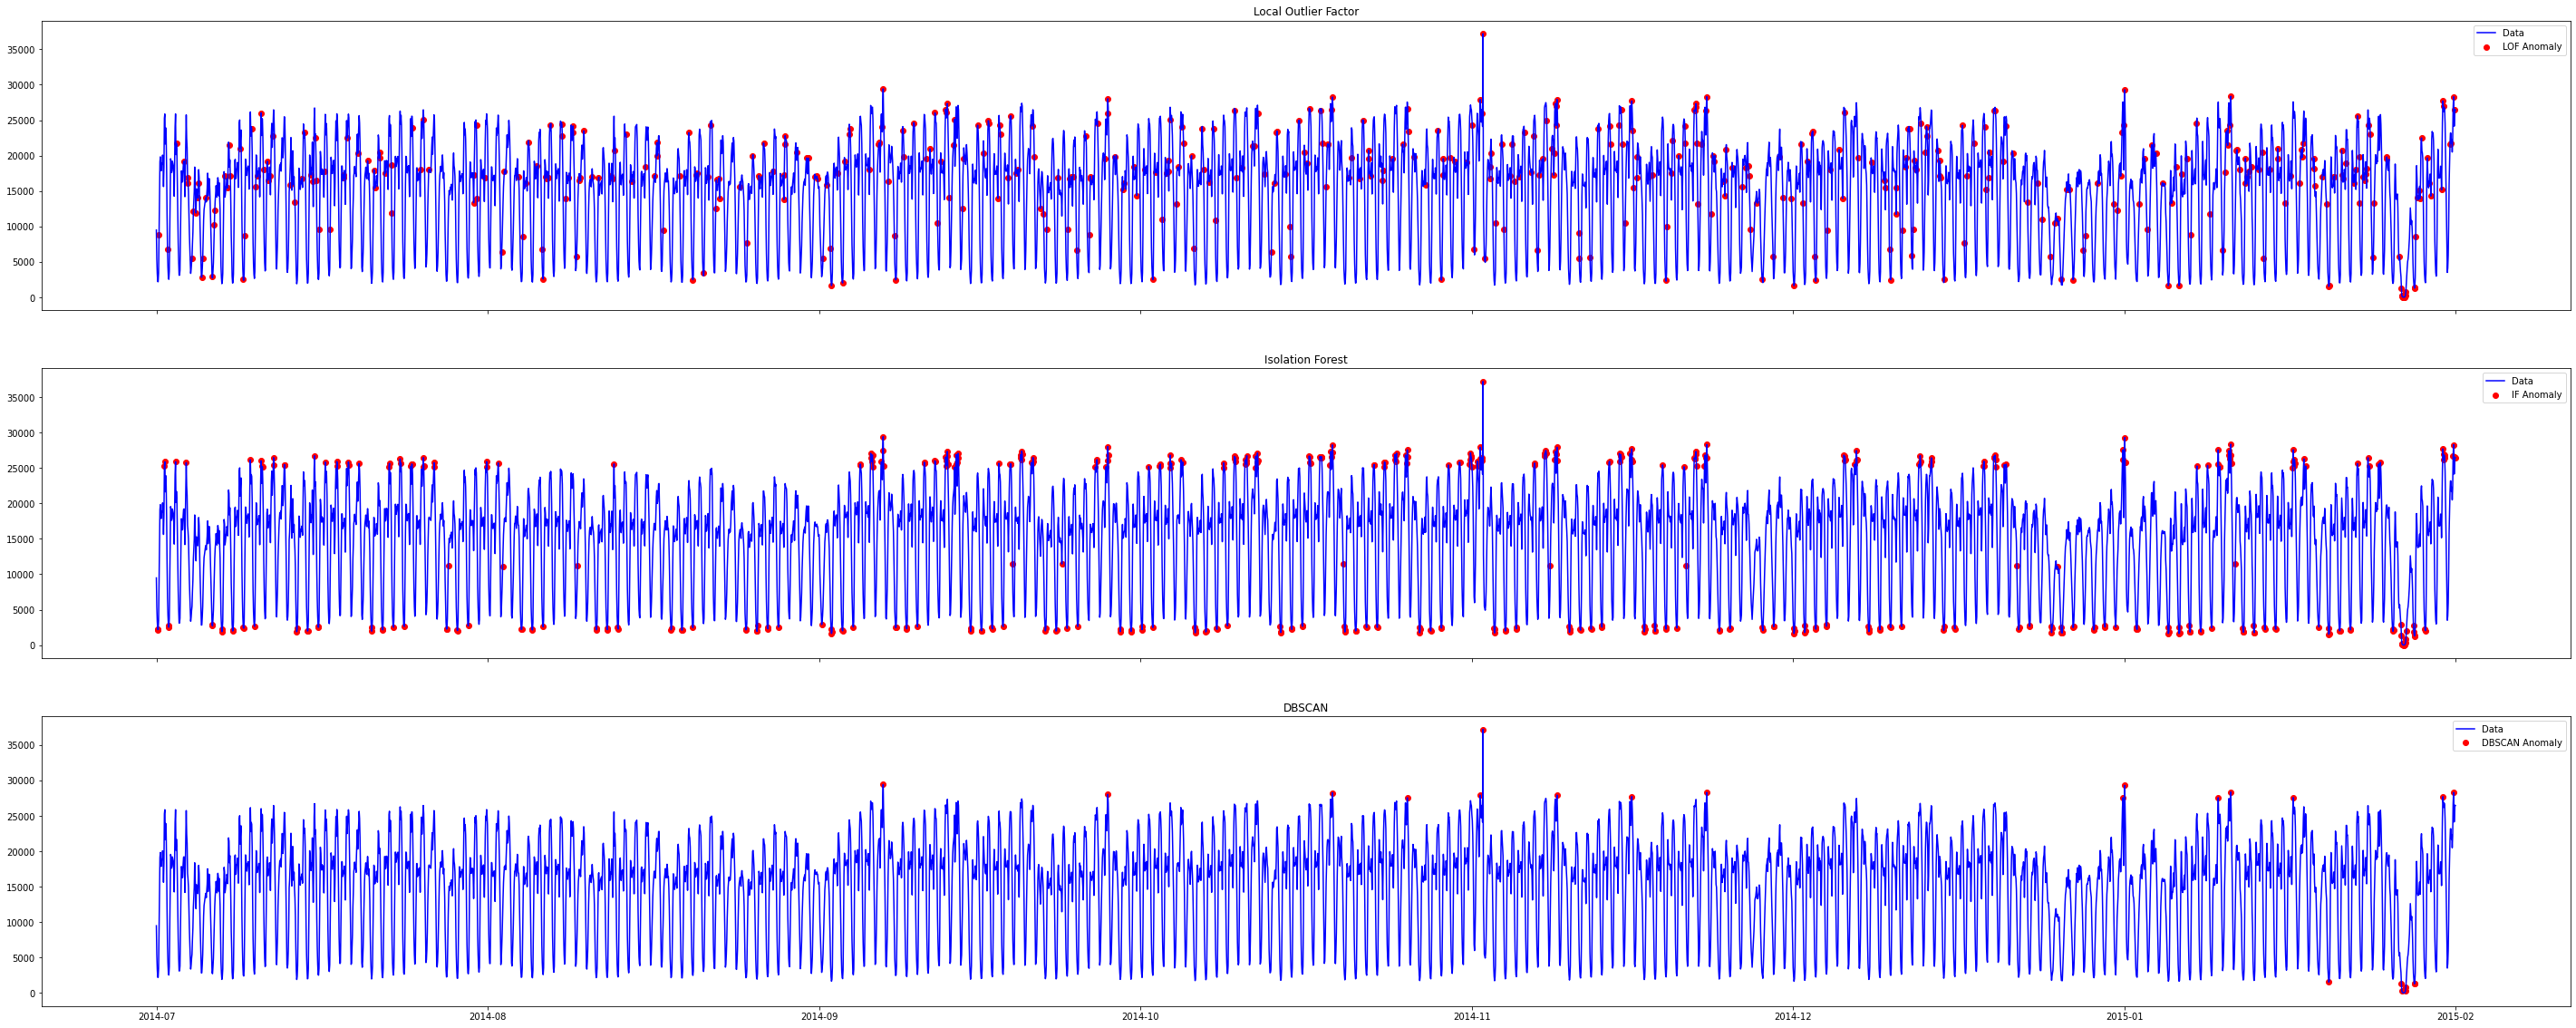

In [13]:
lof_outliers = timeSeries_PerHour.loc[timeSeries_PerHour['Predictions_LocalOutlierFactor'] == -1, ['value']] # -1 is an anomaly
if_outliers = timeSeries_PerHour.loc[timeSeries_PerHour['Predictions_IsolationForest'] == -1, ['value']] # -1 is an anomaly
dbscan_outliers = timeSeries_PerHour.loc[timeSeries_PerHour['Predictions_DBSCAN'] == -1, ['value']] # -1 is an anomaly

fig, axs = plt.subplots(3, figsize=(50,20),sharex=True,sharey=True)
axs[0].plot(timeSeries_PerHour.index, timeSeries_PerHour['value'], color='blue', label = 'Data')
axs[0].scatter(x=lof_outliers.index,y=lof_outliers['value'], color='red', label = 'LOF Anomaly')
axs[0].legend()
axs[0].set_title('Local Outlier Factor')

axs[1].plot(timeSeries_PerHour.index, timeSeries_PerHour['value'], color='blue', label = 'Data')
axs[1].scatter(x=if_outliers.index,y=if_outliers['value'], color='red', label = 'IF Anomaly')
axs[1].legend()
axs[1].set_title('Isolation Forest')

axs[2].plot(timeSeries_PerHour.index, timeSeries_PerHour['value'], color='blue', label = 'Data')
axs[2].scatter(x=dbscan_outliers.index,y=dbscan_outliers['value'], color='red', label = 'DBSCAN Anomaly')
axs[2].legend()
axs[2].set_title('DBSCAN')

Plotting predictions (anomalies) for the whole dataset (30 minute interval).

Using the whole dataset for training and predicting for anomaly detection we again see that Isolation forest worked the best, as the anomalies (red dots) on the graph are mostly where the spikes (blue line) are.

Text(0.5, 1.0, 'DBSCAN')

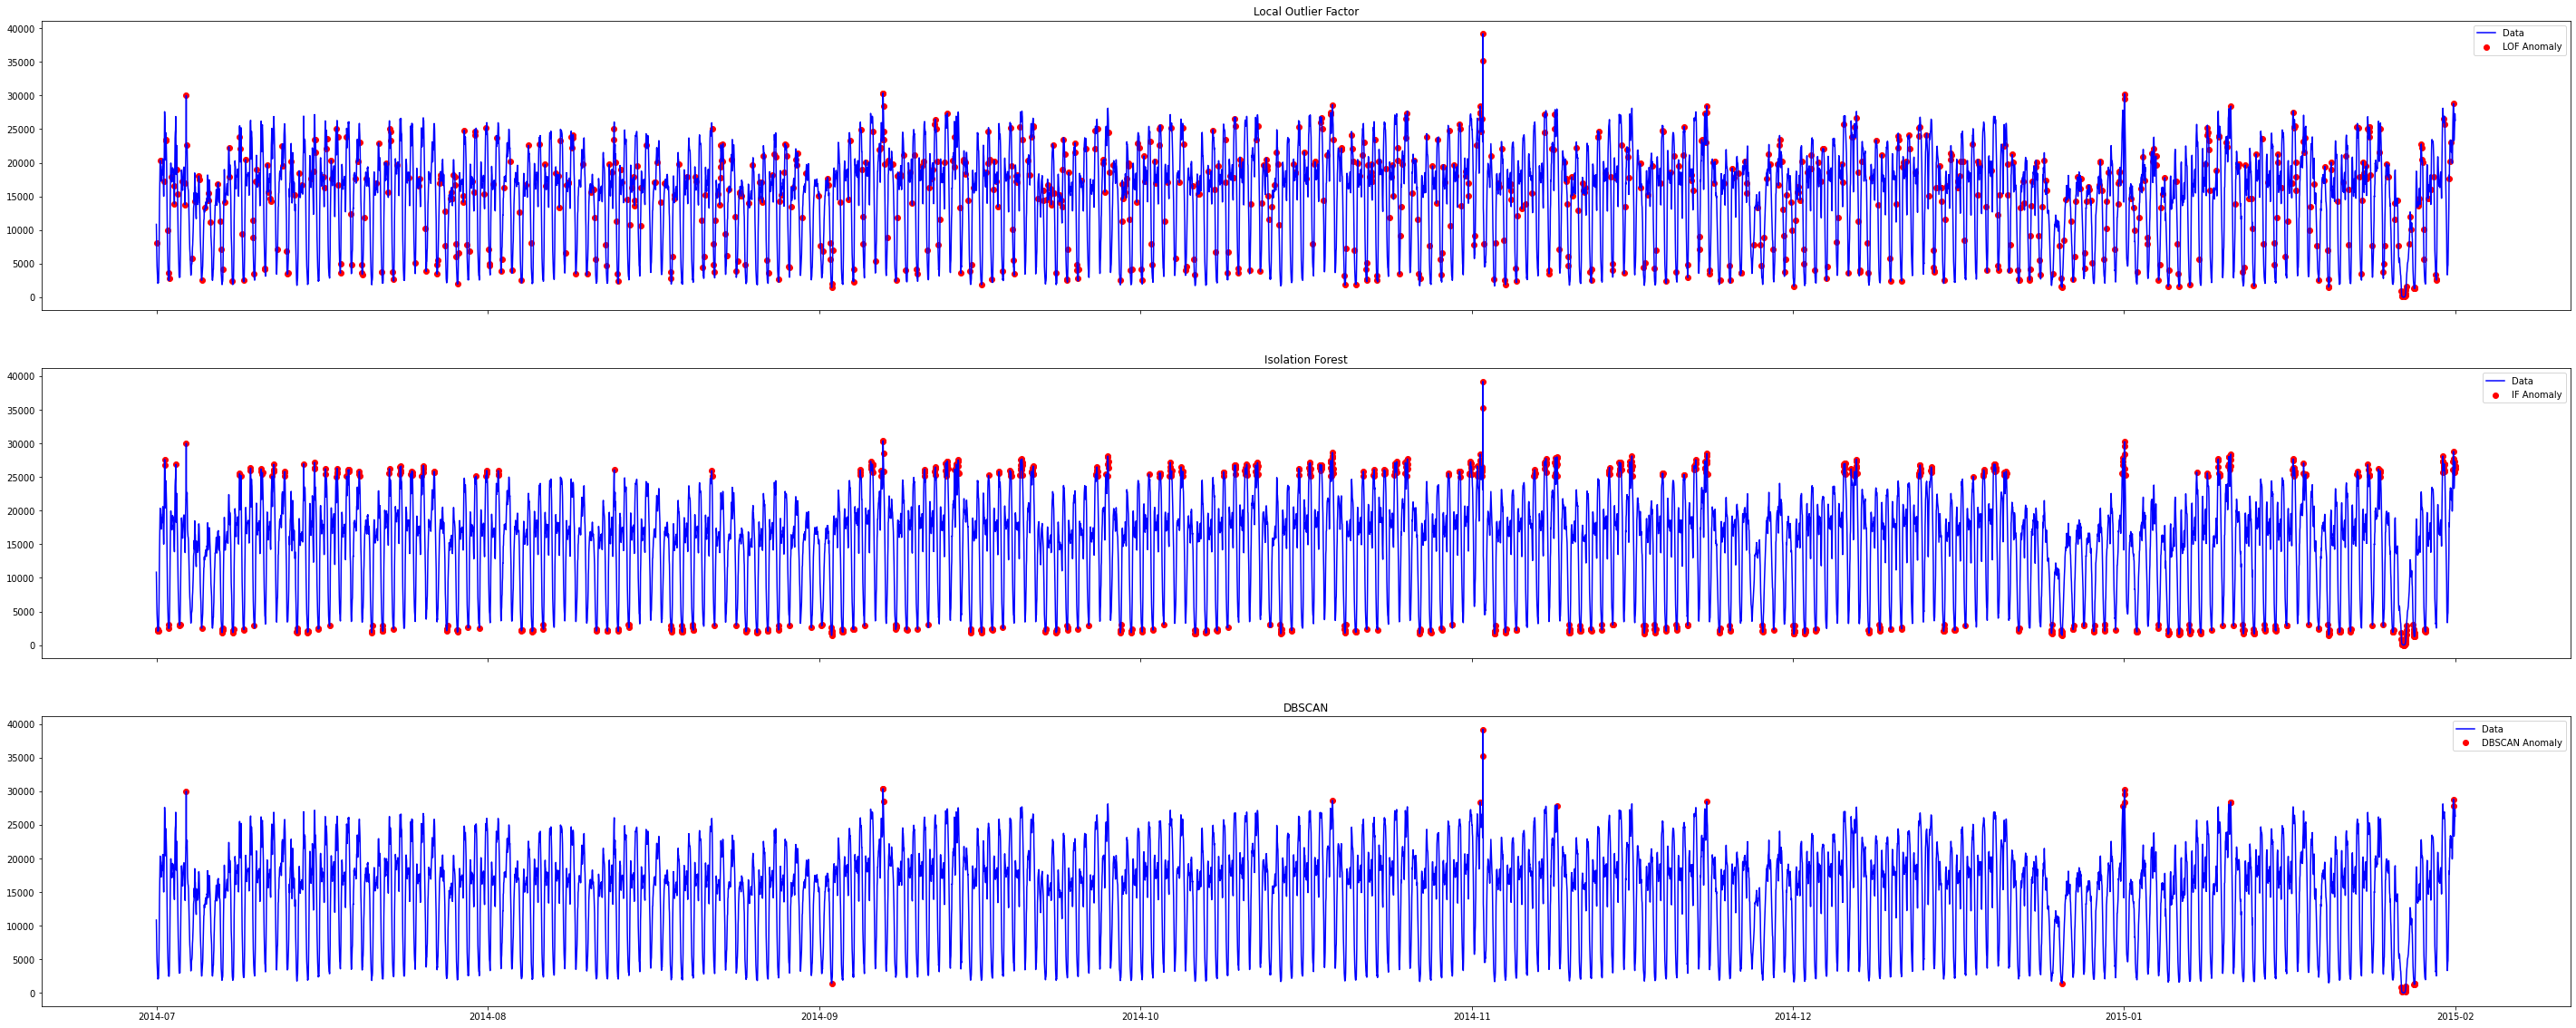

In [14]:
lof_outliers = df.loc[df['Predictions_LocalOutlierFactor'] == -1, ['value']] # -1 is an anomaly
if_outliers = df.loc[df['Predictions_IsolationForest'] == -1, ['value']] # -1 is an anomaly
dbscan_outliers = df.loc[df['Predictions_DBSCAN'] == -1, ['value']] # -1 is an anomaly

fig, axs = plt.subplots(3, figsize=(50,20),sharex=True,sharey=True)
axs[0].plot(df.index, df['value'], color='blue', label = 'Data')
axs[0].scatter(x=lof_outliers.index,y=lof_outliers['value'], color='red', label = 'LOF Anomaly')
axs[0].legend()
axs[0].set_title('Local Outlier Factor')

axs[1].plot(df.index, df['value'], color='blue', label = 'Data')
axs[1].scatter(x=if_outliers.index,y=if_outliers['value'], color='red', label = 'IF Anomaly')
axs[1].legend()
axs[1].set_title('Isolation Forest')

axs[2].plot(df.index, df['value'], color='blue', label = 'Data')
axs[2].scatter(x=dbscan_outliers.index,y=dbscan_outliers['value'], color='red', label = 'DBSCAN Anomaly')
axs[2].legend()
axs[2].set_title('DBSCAN')


**Conclusion:** From all the graphs plotted we can see that Isolation forest performs the best for anomaly detection among the models trained in this notebook. Isolation forest is able find the spike in the graph and does a better job than DBSCAN or Local Outlier Factor.

**Future Work:** For future work, as we have trained mltiple models one idea that came to my mind was to ensemble the trained models and see where all three predict an anomaly that spike is definetly an anomaly with a better precision than only one model predicting it.
